<a href="https://colab.research.google.com/github/rnjt13/Transfer_learning/blob/main/transfer_learning_VGG16_feature_extraction_with_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. !ls - list all files in the current directory
# 2. !mkdir kaggle_1  -> makes a directory named as kaggle_1 inside content folder
# 3. !mkdir -p ~/.kaggle_3  -> makes a directory named as kaggle_3 inside root folder
# 4. Create your API token(Create New Token) from kaggle.com/settings and download the json file

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
# downloading dataset from https://www.kaggle.com/datasets/salader/dogs-vs-cats
!kaggle datasets download -d salader/dogs-vs-cats

 99% 1.06G/1.06G [00:11<00:00, 25.8MB/s]
100% 1.06G/1.06G [00:11<00:00, 101MB/s] 


In [3]:
#unzipping data
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16

In [5]:
# creating an object of VGG16 model to used as CNN layer
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(150,150,3)
)

58889256/58889256 [==============================] - 0s 0us/step


In [6]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [7]:
# Creating ANN layers
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 16812353 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# Keeping CNN paramaters constant, only train ANN parameters
conv_base.trainable = False

In [10]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [11]:
# Using Generators to add data in batches
batch_size = 32

#object of ImageDataGenerator for train, this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

#object of ImageDataGenerator for test, here we do not rescale
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '/content/train',        # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')     # since we use binary_crossentropy loss, we need binary labels

# load images from test folder in batches of 32 and only rescale
validation_generator = test_datagen.flow_from_directory(
        '/content/test',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [12]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [13]:
history = model.fit_generator(
    train_generator,
    epochs=5,
    validation_data= validation_generator
)
# model.fit(train_ds,epochs=5,validation_data=test_ds)

<ipython-input-13-bb5d83bf863b>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/5
625/625 [==============================] - 161s 246ms/step - loss: 0.3071 - accuracy: 0.8648 - val_loss: 0.2129 - val_accuracy: 0.9128
Epoch 2/5
625/625 [==============================] - 152s 243ms/step - loss: 0.2449 - accuracy: 0.8942 - val_loss: 0.2038 - val_accuracy: 0.9144
Epoch 3/5
625/625 [==============================] - 161s 258ms/step - loss: 0.2235 - accuracy: 0.9046 - val_loss: 0.1998 - val_accuracy: 0.9142
Epoch 4/5
625/625 [==============================] - 161s 257ms/step - loss: 0.2077 - accuracy: 0.9101 - val_loss: 0.1935 - val_accuracy: 0.9162
Epoch 5/5
625/625 [==============================] - 151s 242ms/step - loss: 0.2053 - accuracy: 0.9137 - val_loss: 0.1904 - val_accuracy: 0.9190


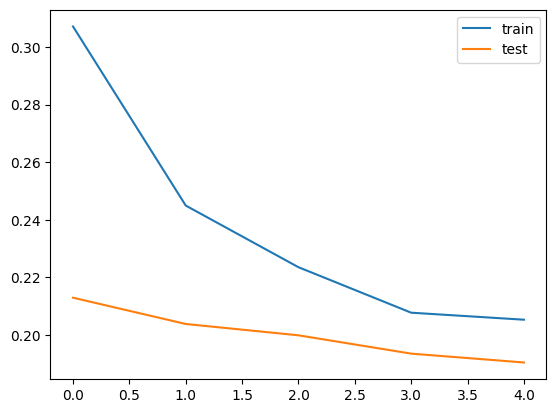

In [14]:
# Plotting train and test loss v/s epochs
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

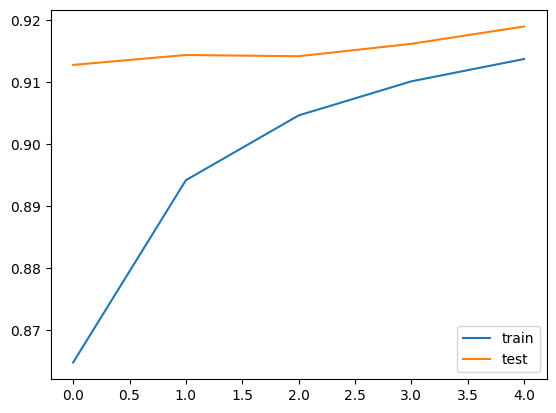

In [15]:
# Plotting train and test accuracy v/s epochs
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.show()

In [16]:
import pickle
pickle.dump(model,open('transfer_learning_VGG16_feature_extraction_with_data_augmentation_pickle.pkl','wb'))